In [1]:
pip install xgboost

  Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:03

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# SENTIMENT ANALYSIS : A COMPARATIVE ANALYSIS BETWEEN MACHINE AND DEEP LEARNING TECHNIQUES

### IMPORTING THE REQUIRED LIBRARIES

In [2]:
import pandas as pd # Importing pandas library and aliasing it as pd
import numpy as np # Importing numpy library and aliasing it as np
import time # tracks time for a certain operation
import psutil # tracks cpu usage
import threading # allows continous monitoring
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer # scaler
from sklearn.model_selection import train_test_split # splitting the dataset
import matplotlib.pyplot as plt # Importing pyplot module from matplotlib library and aliasing it as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler # the oversampler
from sklearn.naive_bayes import MultinomialNB # naive bayes model
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.ensemble import RandomForestClassifier # random forest 
from xgboost import XGBClassifier # extreme gradient boost
from sklearn.ensemble import GradientBoostingClassifier # gradient boost
from sklearn.tree import DecisionTreeClassifier # decision trees
from sklearn.svm import SVC # support vector classifier
import seaborn as sns # Importing seaborn library and aliasing it as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)   # Setting pandas option to display all columns in DataFrame
plt.style.use('ggplot')  # Setting plot style to 'ggplot' from matplotlib

In [3]:
# Reading data from into data DataFrame
data = pd.read_csv("twitter.csv")

In [ ]:
# Reading data from into data DataFrame
data = pd.read_csv("/kaggle/input/omie-dataset/twitter.csv")

In [4]:
# Displaying the DataFrame
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### DATA PREPROCESSING

In this section we would apply the basic text preprocessings, and extract the reviews and rating column from the existing dataset as those would be the only features necessary for the sentiment analysis.

In [5]:
# these are the libraries used for text preprocessing
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
import re
from tqdm.auto import tqdm
import string

[nltk_data] Downloading package wordnet to /home/feng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/feng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/feng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/feng/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
# initializing the stopwords and the stemmer
stop_words = list(stopwords.words("english"))
stemmer = PorterStemmer()

### CREATING A FUNCTION TO PREPROCESS THE WHOLE DATASET IN ONE CALL

In [7]:
def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    
    # remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # remove special characters
    text = re.sub(r"\s+[^a-zA-Z]\s+", " ", text)
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # join tokens back to string
    text = " ".join(tokens)
    
    return text

### APPLYING PREPROCESSING ON THE REVIEWS DATASET

In [8]:
# appplying the text preprocessing
data["tweet"] = data["tweet"].apply(preprocess_text)

In [9]:
# looking at the new dataframe
data.head()

,id,label,tweet
0,1,0,user father dysfunct selfish drag kid dysfunct...
1,2,0,user user thank lyft credit cant use caus dont...
2,3,0,bihday majesti
3,4,0,model love u take u time urð± ðððð...
4,5,0,factsguid societi motiv


####  CHECKING THE UNIQUE VALUES FOR THE TARGET VARIABLES FOR THE MAPPING FUNCTION BELOW.

In [10]:
print(f"Number of Ratings: {data['label'].unique()}")

Number of Ratings: [0 1]


#### VISUALIZING THE LABEL COUNT

In [11]:
label_counts = data["label"].value_counts()

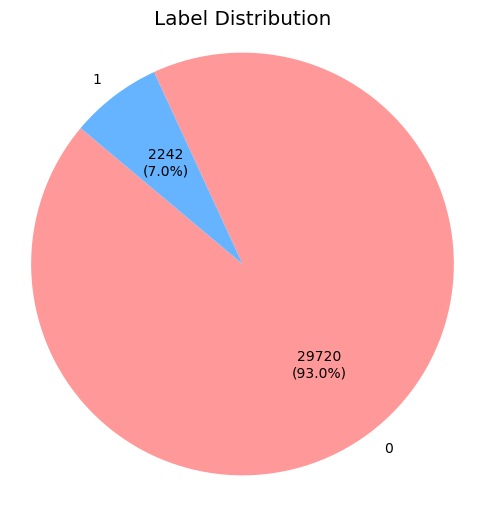

In [12]:
# Create a custom function to display count and percentage
def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{absolute}\n({pct:.1f}%)"

# Define custom colors
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]

# Create plot
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct=lambda pct: autopct_format(pct, label_counts), 
    startangle=140,
    colors=colors
)
plt.title("Label Distribution")
plt.axis("equal")
plt.show()

#### TARGET VARIABLE DISTRIBUTION

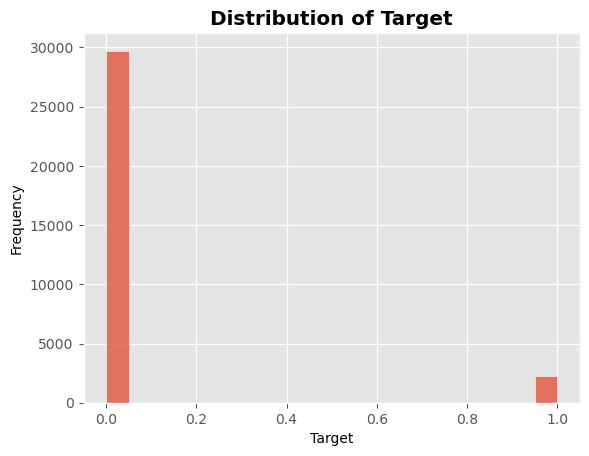

In [13]:
sns.histplot(data["label"], bins=20)
plt.title("Distribution of Target", weight ="bold")
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

#### CHECKING FOR MISSING VALUES

In [14]:
# Counting missing values in each column
missing_values_count = data.isnull().sum()

# Calculating the proportion of missing values for each column
missing_values_proportion= data.isnull().sum() / len(data)

# Combining count and proportion into one DataFrame for a clean summary
missing_values_summary = pd.DataFrame({
    'Missing Values': missing_values_count,
    'Proportion': missing_values_proportion
})
# Displaying the summary table
print(missing_values_summary)

       Missing Values  Proportion
id                  0         0.0
label               0         0.0
tweet               0         0.0


In [15]:
# checking the data type for correctness
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


### DATA SPLITTING INTO DEPENDENT AND INDEPENDENT VARIABLES FOR MODEL TRAINING AND TESTING

In [16]:
# convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words="english")

In [17]:
# separates the dependent and the independent variables
X = data["tweet"] #independent columns
y = data["label"] #target

In [18]:
X = vectorizer.fit_transform(X)

In [19]:
# splits the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

In [20]:
# checking the shape of the train set
X_train.shape

(22373, 37402)

In [21]:
# checking the shape of the train set
y_train.shape

(22373,)

### APPLYING THE RANDOM SAMPLER TO HANDLE DATA IMBALANCE

In [22]:
# initialize random sampler
ros = RandomOverSampler(random_state=46)

In [23]:
# fit the resample on the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

### VISUALIZING THE BALANCED SAMPLED DATA

In [24]:
# initialize the value counts of the labels
label_counts = y_train_resampled.value_counts()

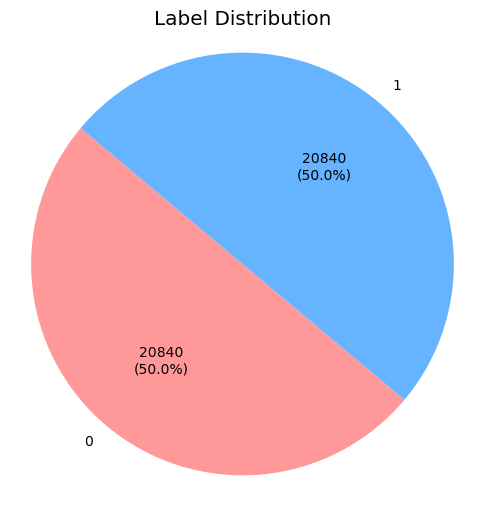

In [25]:
# Create a custom function to display count and percentage
def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{absolute}\n({pct:.1f}%)"

# Define custom colors
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]

# Create plot
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct=lambda pct: autopct_format(pct, label_counts), 
    startangle=140,
    colors=colors
)
plt.title("Label Distribution")
plt.axis("equal")
plt.show()

# CLASSICAL MACHINE LEARNING ALGORITHMS

### MULTINOMIAL NAIVE BAYES

In [26]:
# train the naive model
nb_model = MultinomialNB()

# start tracking the CPU usage and time
cpu_percentage = []
start_time = time.time()

# creating a function to track the average cpu
def cpu_tracker(interval=0.1):
    while True:
        cpu_percentage.append(psutil.cpu_percent(interval=interval))
        
# start CPU tracking in a separate thread
tracker_thread = threading.Thread(target=cpu_tracker)
tracker_thread.start()

nb_model.fit(X_train_resampled, y_train_resampled)

# end the time tracker
end_time = time.time()

# stop CPU tracking
tracker_thread.join(timeout=0)

# calculate time taken and average CPU usage
training_time = end_time - start_time
average_CPU_usage = sum(cpu_percentage) / len(cpu_percentage) if cpu_percentage else 0

In [27]:
print(f"Time taken to train the model: {training_time:.2f} seconds")
print(f"Average CPU usage during training: {average_CPU_usage:.2f}%")

Time taken to train the model: 0.01 seconds
Average CPU usage during training: 0.00%


#### TRAIN ACCURACY

In [27]:
# evaluate the model train predictions
y_pred = nb_model.predict(X_train)

# evaluate the model accuracy
accuracy = accuracy_score(y_train, y_pred)

print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 94.61%


#### TEST ACCURACY

In [28]:
# evaluate the model predictions
y_pred = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {nb_accuracy * 100:.2f}%")

Test Accuracy: 90.50%


In [29]:
# print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95      8880
           1       0.43      0.81      0.56       709

    accuracy                           0.90      9589
   macro avg       0.70      0.86      0.75      9589
weighted avg       0.94      0.90      0.92      9589



#### CONFUSION MATRIX

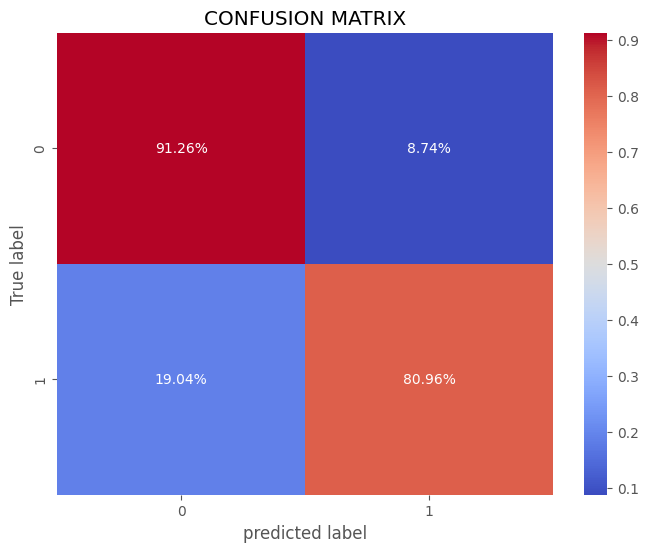

In [30]:
# computes the confusion matrix, which is a table that describes the performance of a classification model.
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
# adjusts the figure size
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="coolwarm", fmt=".2%", cbar=True, xticklabels=label_counts.index, yticklabels=label_counts.index)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

#### ROC CURVE

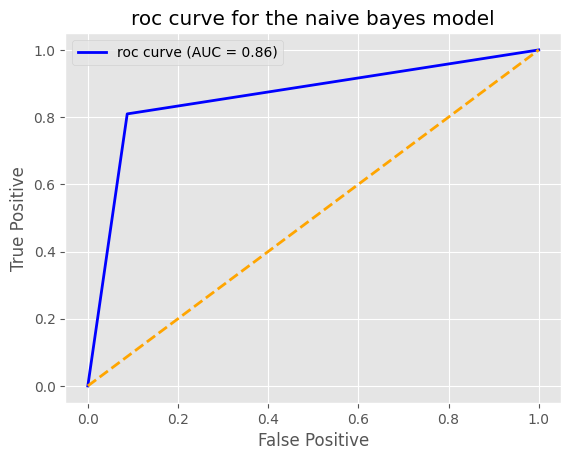

In [31]:
fp, tp, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve for the naive bayes model")
plt.legend()
plt.show()

### LOGISTIC REGRESSION

In [32]:
# train the logistic regression model
lr_model = LogisticRegression(max_iter=10000)

# start tracking the CPU usage and time
cpu_percentage = []
start_time = time.time()

# creating a function to track the average cpu
def cpu_tracker(interval=0.1):
    while True:
        cpu_percentage.append(psutil.cpu_percent(interval=interval))
        
# start CPU tracking in a separate thread
tracker_thread = threading.Thread(target=cpu_tracker)
tracker_thread.start()

lr_model.fit(X_train_resampled, y_train_resampled)

# end the time tracker
end_time = time.time()

# stop CPU tracking
tracker_thread.join(timeout=0)

# calculate time taken and average CPU usage
training_time = end_time - start_time
average_CPU_usage = sum(cpu_percentage) / len(cpu_percentage) if cpu_percentage else 0

In [33]:
print(f"Time taken to train the model: {training_time:.2f} seconds")
print(f"Average CPU usage during training: {average_CPU_usage:.2f}%")

Time taken to train the model: 0.62 seconds
Average CPU usage during training: 52.17%


#### TRAIN ACCURACY

In [34]:
# evaluate the model train predictions
y_pred = lr_model.predict(X_train)

# evaluate the model accuracy
accuracy = accuracy_score(y_train, y_pred)

print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 97.67%


#### TEST ACCURACY

In [35]:
# evaluate the model predictions
y_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {lr_accuracy * 100:.2f}%")

Test Accuracy: 94.69%


In [36]:
# print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      8880
           1       0.62      0.71      0.66       709

    accuracy                           0.95      9589
   macro avg       0.80      0.84      0.82      9589
weighted avg       0.95      0.95      0.95      9589



#### CONFUSION MATRIX

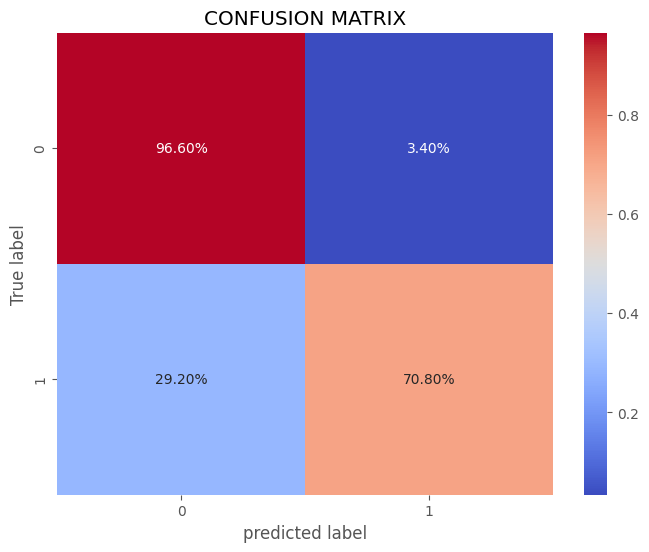

In [37]:
# computes the confusion matrix, which is a table that describes the performance of a classification model.
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
# adjusts the figure size
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="coolwarm", fmt=".2%", cbar=True, xticklabels=label_counts.index, yticklabels=label_counts.index)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

#### ROC CURVE

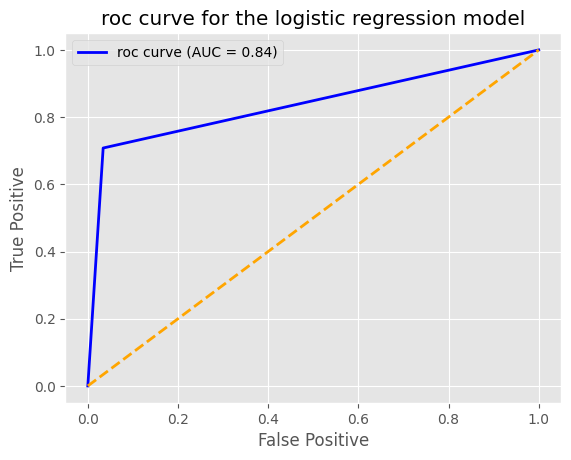

In [38]:
fp, tp, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve for the logistic regression model")
plt.legend()
plt.show()

### RANDOM FOREST CLASSIFIER

In [39]:
rf_model = RandomForestClassifier()

# start tracking the CPU usage and time
cpu_percentage = []
start_time = time.time()

# creating a function to track the average cpu
def cpu_tracker(interval=0.1):
    while True:
        cpu_percentage.append(psutil.cpu_percent(interval=interval))
        
# start CPU tracking in a separate thread
tracker_thread = threading.Thread(target=cpu_tracker)
tracker_thread.start()

rf_model.fit(X_train_resampled, y_train_resampled)

# end the time tracker
end_time = time.time()

# stop CPU tracking
tracker_thread.join(timeout=0)

# calculate time taken and average CPU usage
training_time = end_time - start_time
average_CPU_usage = sum(cpu_percentage) / len(cpu_percentage) if cpu_percentage else 0

In [40]:
print(f"Time taken to train the model: {training_time:.2f} seconds")
print(f"Average CPU usage during training: {average_CPU_usage:.2f}%")

Time taken to train the model: 205.68 seconds
Average CPU usage during training: 36.41%


#### TRAIN ACCURACY

In [41]:
# evaluate the model train predictions
y_pred = rf_model.predict(X_train)

# evaluate the model accuracy
accuracy = accuracy_score(y_train, y_pred)

print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 99.83%


#### TEST ACCURACY

In [42]:
# evaluate the model predictions
y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {rf_accuracy * 100:.2f}%")

Test Accuracy: 94.11%


In [43]:
# print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8880
           1       0.63      0.50      0.56       709

    accuracy                           0.94      9589
   macro avg       0.79      0.74      0.76      9589
weighted avg       0.94      0.94      0.94      9589



#### CONFUSION MATRIX

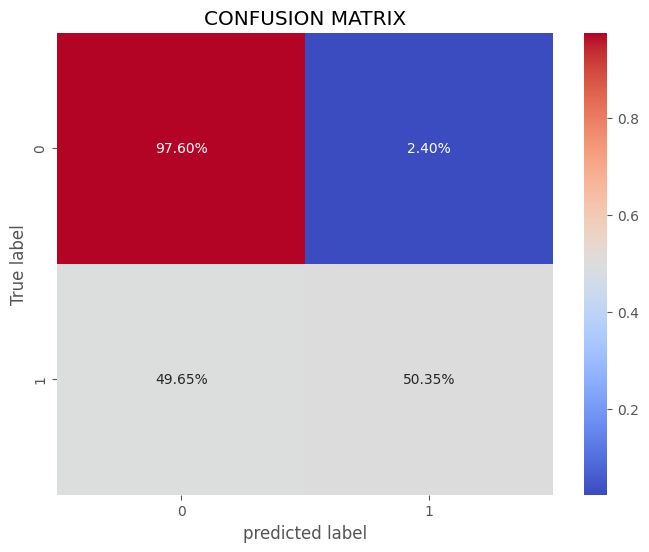

In [44]:
# computes the confusion matrix, which is a table that describes the performance of a classification model.
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
# adjusts the figure size
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="coolwarm", fmt=".2%", cbar=True, xticklabels=label_counts.index, yticklabels=label_counts.index)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

#### ROC CURVE

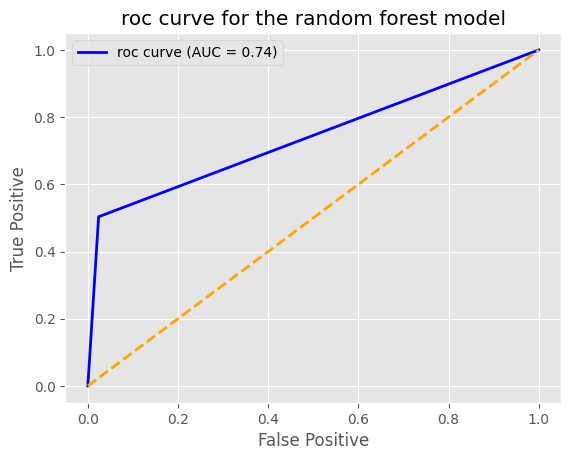

In [45]:
fp, tp, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve for the random forest model")
plt.legend()
plt.show()

### EXTREME GRADIENT BOOSTING CLASSIFIER

In [46]:
xgb_model = XGBClassifier(learning_rate = 0.001, max_depth = 100, n_estimators = 300)

# start tracking the CPU usage and time
cpu_percentage = []
start_time = time.time()

# creating a function to track the average cpu
def cpu_tracker(interval=0.1):
    while True:
        cpu_percentage.append(psutil.cpu_percent(interval=interval))
        
# start CPU tracking in a separate thread
tracker_thread = threading.Thread(target=cpu_tracker)
tracker_thread.start()

xgb_model.fit(X_train_resampled, y_train_resampled)

# end the time tracker
end_time = time.time()

# stop CPU tracking
tracker_thread.join(timeout=0)

# calculate time taken and average CPU usage
training_time = end_time - start_time
average_CPU_usage = sum(cpu_percentage) / len(cpu_percentage) if cpu_percentage else 0

In [47]:
print(f"Time taken to train the model: {training_time:.2f} seconds")
print(f"Average CPU usage during training: {average_CPU_usage:.2f}%")

Time taken to train the model: 1098.15 seconds
Average CPU usage during training: 96.28%


#### TRAIN ACCURACY

In [48]:
# evaluate the model train predictions
y_pred = xgb_model.predict(X_train)

# evaluate the model accuracy
accuracy = accuracy_score(y_train, y_pred)

print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 97.35%


#### TEST ACCURACY

In [49]:
# evaluate the model predictions
y_pred = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {xgb_accuracy * 100:.2f}%")

Accuracy: 92.76%


In [50]:
# print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      8880
           1       0.51      0.51      0.51       709

    accuracy                           0.93      9589
   macro avg       0.74      0.73      0.74      9589
weighted avg       0.93      0.93      0.93      9589



#### CONFUSION MATRIX

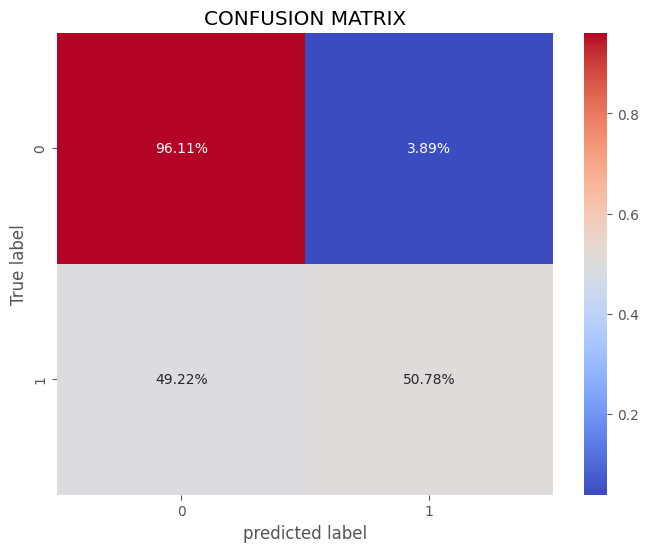

In [51]:
# computes the confusion matrix, which is a table that describes the performance of a classification model.
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
# adjusts the figure size
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="coolwarm", fmt=".2%", cbar=True, xticklabels=label_counts.index, yticklabels=label_counts.index)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

#### ROC CURVE

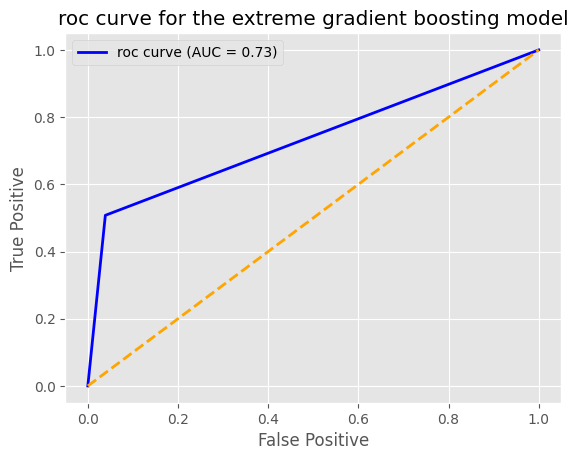

In [52]:
fp, tp, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve for the extreme gradient boosting model")
plt.legend()
plt.show()

#### GENERAL ROC

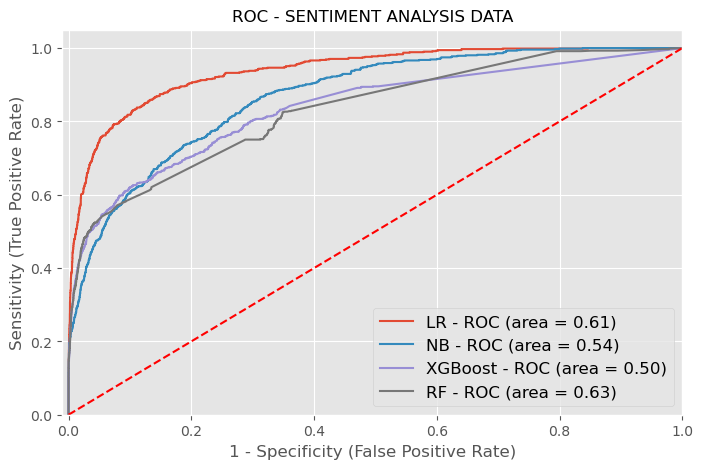

In [58]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'LR',
    'model': lr_model,
},
{
    'label': 'NB',
    'model': nb_model,
},
{
    'label': 'XGBoost',
    'model': xgb_model,
},
{
    'label': 'RF',
    'model': rf_model,
}
    
]
for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred=model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - SENTIMENT ANALYSIS DATA', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("roc_reviews.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# IMPLEMENTING THE TRANSFORMER NEURAL NETWORK (BERT AND DISTILBERT)

In [2]:
pip install --upgrade protobuf

  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.59.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.29.2 which is incompatible.
tensorflow 2.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.2 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup, DistilBertTokenizer, DistilBertModel
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm

#### INITIALIZATIONS

In [29]:
# the random seed aids repetition and production of deterministic results 
RANDOM_SEED = 46
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# initialization of default training unit to CPU if GPU is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
BATCH_SIZE = 32

#### SPLITTING THE DATASET INTO TRAIN, VAL AND TEST

In [30]:
df_train, df_temp = train_test_split(data, test_size=0.4, shuffle=True, random_state=RANDOM_SEED)

In [31]:
df_val, df_test = train_test_split(df_temp, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

In [32]:
print(df_train.shape, df_test.shape, df_val.shape)

(19177, 3) (6393, 3) (6392, 3)


# CREATING A CUSTOM DATASET CLASS WITH RESPECT TO THE PYTORCH FRAMEWORK

In [33]:
class SentimentDataset(Dataset):
    def __init__(self, df, reviews, targets, tokenizer, max_len, model_type="bert", include_raw_text=False):
        """
        Initializes the dataset class for BERT and DistilBERT models.

        Parameters:
        - df (DataFrame): The dataset
        - reviews (list): The column containing the text data
        - targets (list): The column containing the target labels
        - tokenizer: Tokenizer for encoding text data
        - max_len (int): Maximum sequence length
        - model_type (str): Model type, either "bert" or "distilbert"
        - include_raw_text (bool): Whether to include the raw text in the output
        """
        self.df = df
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.model_type = model_type.lower()
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        target = self.targets[idx]

        # Tokenize the review
        input_encoding = self.tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        # Initialize output dictionary
        output = {
            "input_ids": input_encoding["input_ids"].flatten(),
            "attention_mask": input_encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long),
        }

        # Add `token_type_ids` only for BERT, not DistilBERT
        if self.model_type == "bert" and "token_type_ids" in input_encoding:
            output["token_type_ids"] = input_encoding["token_type_ids"].flatten()

        # Optionally include raw text
        if self.include_raw_text:
            output["review_text"] = review

        return output

In [34]:
# Initialize the DistilBERT tokenizer
tokenizer_distilbert = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Initialize the BERT tokenizer
tokenizer_BERT = BertTokenizer.from_pretrained("bert-base-uncased")

# Set up a collator with padding
collator = DataCollatorWithPadding(tokenizer = tokenizer_BERT, padding="longest")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [35]:
# looking at the collator properties
collator

DataCollatorWithPadding(tokenizer=BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding='longest', max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## CREATING A DATALOADER

In [36]:
def create_data_loader(data, tokenizer, model_type="bert", max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False):
    """
    Creates a DataLoader for BERT or DistilBERT sentiment analysis model.

    Parameters:
    - data: The DataFrame containing text and labels
    - tokenizer: The tokenizer to be used (BERT or DistilBERT)
    - model_type (str): The model type, either "bert" or "distilbert"
    - max_len (int): The maximum length for tokenized input
    - batch_size (int): The batch size for the DataLoader
    - include_raw_text (bool): Whether to include the raw text in the dataset output

    Returns:
    - DataLoader: The PyTorch DataLoader for training or evaluation
    """
    
    # Set pad_token for GPT tokenizer if model_type is "gpt" (though not needed for BERT/DistilBERT)
    if model_type == "gpt" and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Initialize the dataset with model_type passed as a parameter
    dataset = SentimentDataset(
        df=data,
        reviews=data["tweet"].to_list(),
        targets=data["label"].to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        model_type=model_type,
        include_raw_text=include_raw_text
    )

    # Set up the collator with padding behavior based on model type
    # Padding for BERT and DistilBERT should be "max_length", as "longest" may cause issues with different sequence lengths.
    collator = DataCollatorWithPadding(
        tokenizer=tokenizer, 
        padding="max_length"  # BERT and DistilBERT typically use max_length padding
    )

    return DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

#### DATALOADER INITIALIZATION

#### BERT

In [37]:
# pytorch dataloader implementation for the train dataloader
train_dataloader_bert = create_data_loader(df_train, tokenizer=tokenizer_BERT, model_type="bert")
# pytorch dataloader implementation for the validation dataloader
test_dataloader_bert = create_data_loader(df_test, tokenizer=tokenizer_BERT, model_type="bert")
# pytorch dataloader implementation for the test dataloader
val_dataloader_bert = create_data_loader(df_val, tokenizer=tokenizer_BERT, model_type="bert")

#### DistilBERT

In [38]:
# pytorch dataloader implementation for the train dataloader
train_dataloader_distil = create_data_loader(df_train, tokenizer=tokenizer_distilbert, model_type="distilbert")
# pytorch dataloader implementation for the validation dataloader
test_dataloader_distil = create_data_loader(df_test, tokenizer=tokenizer_distilbert, model_type="distilbert")
# pytorch dataloader implementation for the test dataloader
val_dataloader_distil = create_data_loader(df_val, tokenizer=tokenizer_distilbert, model_type="distilbert")

# THE BERT TRANSFORMER MODEL

In [39]:
class BERTClassifier(nn.Module):
    """This class calls the BERT weight from the pytorch library for pretrained models, fine tunes it to suit
    the number of classes for our desired task then outputs the tuned model"""
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        #Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained("bert-base-uncased", return_dict = False, from_tf = False) #body
        self.drop = nn.Dropout(0.3)
        #Ths will replace the final fully connected layer with a new one
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids
        )

        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [40]:
model_bert = BERTClassifier(num_classes=2)

In [41]:
model_bert.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

# THE DISTIL BERT TRANSFORMER MODEL

In [42]:
class DistilBERTClassifier(nn.Module):
    """This class loads the DistilBERT weight from the transformers library, fine-tunes it to suit
    the number of classes for our desired task, and outputs the tuned model."""
    
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        # Load the pre-trained DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.drop = nn.Dropout(0.3)
        # This will replace the final fully connected layer with a new one
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)  # Using hidden size from DistilBERT config

    def forward(self, input_ids, attention_mask):
        # DistilBERT outputs a tuple (last_hidden_state, attention_mask)
        output = self.distilbert(input_ids=input_ids,
                                 attention_mask=attention_mask)
        last_hidden_state = output[0]  # Extract the last hidden state

        # Use the hidden state corresponding to the [CLS] token (usually the first token)
        pooled_output = last_hidden_state[:, 0, :]  # Shape (batch_size, hidden_size)

        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [43]:
model_distil = DistilBERTClassifier(num_classes=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [44]:
model_distil.to(device)

DistilBERTClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

### LOSS FUNCTION AND OPTIMIZER FOR BOTH MODELS

In [61]:
# CrossEntropyLoss is appropriate for multi-class or binary classification
criterion = nn.CrossEntropyLoss() 

# Adam is a good choice for deep learning models for BERT
optimizer_bert = optim.Adam(model_bert.parameters(), lr=3e-5)  

# Adam is a good choice for deep learning models for GPT
optimizer_distil_bert = optim.Adam(model_distil.parameters(), lr=3e-5) 

# Number of epochs and total steps for training
NUM_EPOCHS = 10
total_steps_bert = len(train_dataloader_bert) * NUM_EPOCHS
total_steps_gpt = len(train_dataloader_distil) * NUM_EPOCHS

# Scheduler: Linear schedule with warm-up
scheduler_bert = get_linear_schedule_with_warmup(optimizer_bert, num_warmup_steps=0, num_training_steps=total_steps_bert)
scheduler_distil = get_linear_schedule_with_warmup(optimizer_distil_bert, num_warmup_steps=0, num_training_steps=total_steps_gpt)

## BERT TRAINING

In [25]:
# The training loop is a PyTorch convention. It trains the model using the train data loader and evaluates it using the validation data loader.
# Storing the loss and accuracy value for each epoch
train_losses = []
accuracy = []
val_losses = []
accuracy_val = []

# Validation items
val_correct = 0
val_total = 0
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_running_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Initializing the prediction count to zero before the loop
    correct = 0
    total = 0

    # Train loop
    model_bert.train()  # Set model to training mode
    
    for idx, batch in tqdm(enumerate(train_dataloader_bert), total = len(train_dataloader_bert)):
        # Moves the input data (input_ids, attention mask, token type, and targets) to the specified device
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model_bert(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, targets)

        # Accumulate training loss for each batch
        train_running_loss += loss.item()
        train_losses.append(loss.item())
        
        # Compute the number of correct predictions for the current batch
        _, predicted = torch.max(outputs, dim=1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Backpropagation
        loss.backward()

        # Gradient descent
        optimizer_bert.step()
        optimizer_bert.zero_grad()
    
    # Update the learning rate scheduler
    scheduler_bert.step()
    
    epoch_loss = train_running_loss / len(train_dataloader_bert)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.3f}")
    train_accuracy = 100 * (correct / total)
    accuracy.append(train_accuracy)
    
    # Validation loop
    model_bert.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # No gradients needed for validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        for idx, batch in tqdm(enumerate(val_dataloader_bert), total = len(val_dataloader_bert)):
            # Moves the input data (input_ids, attention mask, token type, and targets) to the specified device
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.long)
        
            # Forward pass
            outputs = model_bert(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, targets)
        
            # Accumulate validation loss
            val_loss += loss.item()
        
            # Compute the number of correct predictions for the validation batch
            _, predicted = torch.max(outputs, dim=1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
        
        # Calculate the average validation loss
        val_loss /= len(val_dataloader_bert)
        
        # Calculate validation accuracy
        val_accuracy = 100 * (val_correct / val_total)
        
        # Store accuracy values for validation
        accuracy_val.append(val_accuracy)
        
        # Store validation loss
        val_losses.append(val_loss)
        
        # Print training and validation results
        print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 loss: 0.134


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 95.50%, Validation Accuracy: 96.28%, Training Loss: 0.1343, Validation Loss: 0.1129
Epoch [2/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 loss: 0.057


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 97.97%, Validation Accuracy: 96.57%, Training Loss: 0.0572, Validation Loss: 0.1373
Epoch [3/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 loss: 0.026


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 99.11%, Validation Accuracy: 96.43%, Training Loss: 0.0261, Validation Loss: 0.1564
Epoch [4/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 loss: 0.018


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 99.39%, Validation Accuracy: 96.54%, Training Loss: 0.0179, Validation Loss: 0.1604
Epoch [5/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 loss: 0.008


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 99.72%, Validation Accuracy: 96.42%, Training Loss: 0.0080, Validation Loss: 0.1492
Epoch [6/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6 loss: 0.008


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 99.72%, Validation Accuracy: 96.45%, Training Loss: 0.0078, Validation Loss: 0.1989
Epoch [7/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7 loss: 0.003


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 99.90%, Validation Accuracy: 96.75%, Training Loss: 0.0035, Validation Loss: 0.2092
Epoch [8/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8 loss: 0.004


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 99.85%, Validation Accuracy: 96.23%, Training Loss: 0.0044, Validation Loss: 0.1699
Epoch [9/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 9 loss: 0.003


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 99.91%, Validation Accuracy: 96.46%, Training Loss: 0.0026, Validation Loss: 0.2763
Epoch [10/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 10 loss: 0.006


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 99.81%, Validation Accuracy: 95.28%, Training Loss: 0.0060, Validation Loss: 0.2091


## BERT TESTING

In [26]:
# Initialize the total sample count and correct prediction count to zero
correct_pred = 0.0
total_samples = 0.0

# Storing all the loss, predictions, and label values for the test
test_losses = []
all_predictions = []
all_labels = []

model_bert.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_loss = 0.0
    for batch in tqdm(test_dataloader_bert, total=len(test_dataloader_bert)):
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)  # This is necessary for BERT
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model_bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = criterion(outputs, targets)

        # Accumulate the loss
        test_loss += loss.item()
        test_losses.append(loss.item())

        # Get predictions
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)

        # Calculate accuracy
        correct_pred += (predicted == targets).sum()

        # Store the predicted and actual labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Calculate the average test loss and accuracy after completing the testing/validation phase
test_loss /= len(test_dataloader_bert)
accuracy = correct_pred / total_samples

# Print the results
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(test_loss, accuracy * 100))

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.214 | Accuracy: 95.401


#### CLASSIFICATION REPORT FOR BERT

In [27]:
# these are gotten from the sklearn library
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average = "weighted")
recall = recall_score(all_labels, all_predictions, average = "weighted")
f1 = f1_score(all_labels, all_predictions, average = "weighted")

#### BERT RESULTS

In [28]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

Accuracy: 0.954, precision: 0.962, recall: 0.954, F1: 0.957


In [29]:
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5913
           1       0.65      0.84      0.73       480

    accuracy                           0.95      6393
   macro avg       0.82      0.90      0.85      6393
weighted avg       0.96      0.95      0.96      6393



#### ROC CURVE FOR BERT

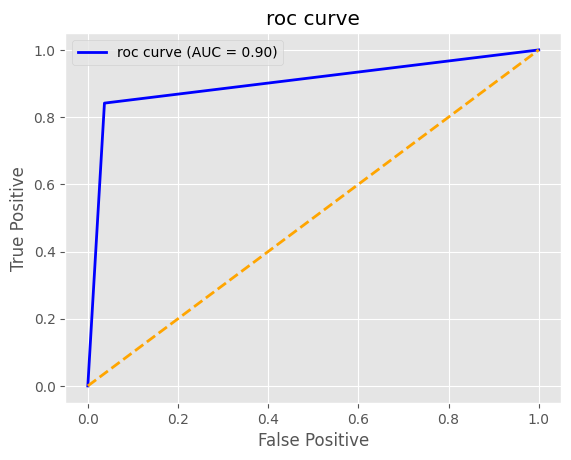

In [33]:
fp, tp, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve")
plt.legend()
plt.show()

## DISTIL BERT TRAINING

In [43]:
torch.cuda.empty_cache()

In [29]:
# The training loop is a PyTorch convention. It trains the model using the train data loader and evaluates it using the validation data loader.
# Storing the loss and accuracy value for each epoch
train_losses = []
accuracy = []
val_losses = []
accuracy_val = []

# Validation items
val_correct = 0
val_total = 0
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_running_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Initializing the prediction count to zero before the loop
    correct = 0
    total = 0

    # Train loop
    model_distil.train()  # Set model to training mode
    
    for idx, batch in tqdm(enumerate(train_dataloader_distil), total = len(train_dataloader_distil)):
        # Moves the input data (input_ids, attention mask, and targets) to the specified device
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model_distil(input_ids, attention_mask=attention_mask)  # No token_type_ids for DistilBERT
        loss = criterion(outputs, targets)

        # Accumulate training loss for each batch
        train_running_loss += loss.item()
        train_losses.append(loss.item())
        
        # Compute the number of correct predictions for the current batch
        _, predicted = torch.max(outputs, dim=1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Backpropagation
        loss.backward()

        # Gradient descent
        optimizer_distil_bert.step()
        optimizer_distil_bert.zero_grad()
    
    # Update the learning rate scheduler
    scheduler_distil.step()
    
    epoch_loss = train_running_loss / len(train_dataloader_distil)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.3f}")
    train_accuracy = 100 * (correct / total)
    accuracy.append(train_accuracy)
    
    # Validation loop
    model_distil.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # No gradients needed for validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        for idx, batch in tqdm(enumerate(val_dataloader_distil), total = len(val_dataloader_distil)):
            # Moves the input data (input_ids, attention mask, and targets) to the specified device
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.long)
        
            # Forward pass
            outputs = model_distil(input_ids, attention_mask=attention_mask)  # No token_type_ids for DistilBERT
            loss = criterion(outputs, targets)
        
            # Accumulate validation loss
            val_loss += loss.item()
        
            # Compute the number of correct predictions for the validation batch
            _, predicted = torch.max(outputs, dim=1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
        
        # Calculate the average validation loss
        val_loss /= len(val_dataloader_distil)
        
        # Calculate validation accuracy
        val_accuracy = 100 * (val_correct / val_total)
        
        # Store accuracy values for validation
        accuracy_val.append(val_accuracy)
        
        # Store validation loss
        val_losses.append(val_loss)
        
        # Print training and validation results
        print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 loss: 0.147


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 95.05%, Validation Accuracy: 96.10%, Training Loss: 0.1474, Validation Loss: 0.1158
Epoch [2/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 loss: 0.069


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 97.55%, Validation Accuracy: 96.26%, Training Loss: 0.0692, Validation Loss: 0.1417
Epoch [3/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 loss: 0.033


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 98.90%, Validation Accuracy: 96.29%, Training Loss: 0.0325, Validation Loss: 0.1694
Epoch [4/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 loss: 0.019


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 99.33%, Validation Accuracy: 94.90%, Training Loss: 0.0190, Validation Loss: 0.2114
Epoch [5/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 loss: 0.013


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 99.61%, Validation Accuracy: 95.70%, Training Loss: 0.0130, Validation Loss: 0.1814
Epoch [6/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6 loss: 0.006


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 99.80%, Validation Accuracy: 96.06%, Training Loss: 0.0063, Validation Loss: 0.2382
Epoch [7/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7 loss: 0.003


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 99.90%, Validation Accuracy: 96.18%, Training Loss: 0.0030, Validation Loss: 0.2870
Epoch [8/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8 loss: 0.005


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 99.90%, Validation Accuracy: 96.07%, Training Loss: 0.0050, Validation Loss: 0.2426
Epoch [9/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 9 loss: 0.005


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 99.89%, Validation Accuracy: 95.99%, Training Loss: 0.0049, Validation Loss: 0.2674
Epoch [10/10]


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 10 loss: 0.005


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 99.85%, Validation Accuracy: 96.10%, Training Loss: 0.0046, Validation Loss: 0.2732


#### SAVE MODEL

In [39]:
# Save the model's state_dict to a file in the Kaggle environment
torch.save(model_distil.state_dict(), '/kaggle/working/model_state_dict.pth')

#### LOAD MODEL

In [53]:
model_distil = DistilBERTClassifier(num_classes=2).to(device)

In [54]:
model_distil.load_state_dict(torch.load('model_state_dict.pth', map_location=device))

<All keys matched successfully>

## DISTIL BERT TESTING

In [63]:
# Initialize the total sample count and correct prediction count to zero
correct_pred = 0.0
total_samples = 0.0

# Storing all the loss, predictions, and label values for the test
test_losses = []
all_predictions = []
all_labels = []

model_distil.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_loss = 0.0
    for batch in tqdm(test_dataloader_distil, total=len(test_dataloader_distil)):
        # Moves the input data (input_ids, attention mask, and targets) to the specified device
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass for DistilBERT
        outputs = model_distil(input_ids, attention_mask=attention_mask)  # No token_type_ids for DistilBERT
        
        
        loss = criterion(outputs, targets)

        # Accumulate the loss
        test_loss += loss.item()
        test_losses.append(loss.item())

        # Get predictions (choose the token with the highest probability)
        _, predicted = torch.max(outputs, dim=-1)
        total_samples += targets.size(0)

        # Calculate accuracy
        correct_pred += (predicted == targets).sum()

        # Store the predicted and actual labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Calculate the average test loss and accuracy after completing the testing phase
test_loss /= len(test_dataloader_distil)
accuracy = correct_pred / total_samples

# Print the results
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(test_loss, accuracy * 100))

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.258 | Accuracy: 96.277


#### CLASSIFICATION REPORT FOR DISTIL BERT

In [64]:
# these are gotten from the sklearn library
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average = "weighted")
recall = recall_score(all_labels, all_predictions, average = "weighted")
f1 = f1_score(all_labels, all_predictions, average = "weighted")

#### DISTILBERT RESULTS

In [65]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

Accuracy: 0.963, precision: 0.960, recall: 0.963, F1: 0.960


In [66]:
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5913
           1       0.86      0.60      0.71       480

    accuracy                           0.96      6393
   macro avg       0.92      0.80      0.84      6393
weighted avg       0.96      0.96      0.96      6393



#### ROC CURVE FOR DISTIL BERT

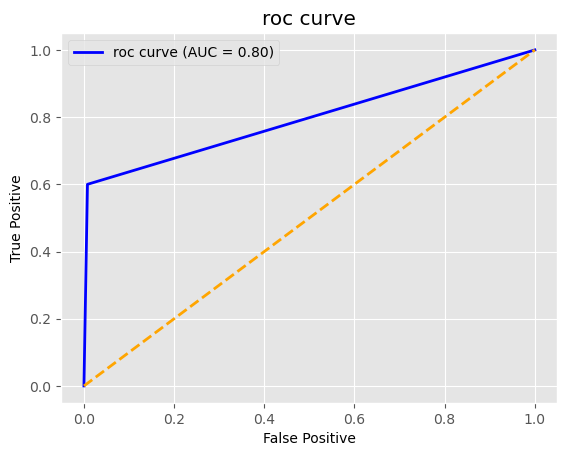

In [67]:
fp, tp, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve")
plt.legend()
plt.show()